In [39]:
# Data manipulation
import pandas as pd
import numpy as np
from pprint import pprint
from collections import OrderedDict
from numpy.linalg import multi_dot

from scipy import stats
from tabulate import tabulate

# Import plotly express
import plotly.express as px
px.defaults.width, px.defaults.height = 1000, 600

import warnings 
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 4)

In [2]:
# Read from file
df = pd.read_csv('data/india_stocks.csv', index_col=0, parse_dates=True)

# Display dataframe
df

,ASIANPAINT,HDFCBANK,ITC,RELIANCE,TCS
Date,,,,,
2015-01-01,704.9196,446.3565,191.1796,417.9889,1065.1387
2015-01-02,729.2904,452.5686,191.7784,416.8826,1079.3239
2015-01-05,729.2433,448.7476,192.5334,412.3163,1062.9210
2015-01-06,711.8356,441.7619,187.5866,393.6035,1023.7346
2015-01-07,726.1381,443.0512,184.0979,402.1713,1011.6423
...,...,...,...,...,...
2022-12-26,3035.8335,1610.9755,327.3880,2524.0500,3156.5701
2022-12-27,3092.0093,1612.6068,325.9692,2544.7000,3162.9749
2022-12-28,3103.0359,1611.3215,327.1923,2544.4500,3160.6460


In [3]:
# Calculate daily returns
returns = df.pct_change().dropna()
returns.head()

,ASIANPAINT,HDFCBANK,ITC,RELIANCE,TCS
Date,,,,,
2015-01-02,3.4573e-02,0.0139,0.0031,-0.0026,0.0133
2015-01-05,-6.4526e-05,-0.0084,0.0039,-0.0110,-0.0152
2015-01-06,-2.3871e-02,-0.0156,-0.0257,-0.0454,-0.0369
2015-01-07,2.0092e-02,0.0029,-0.0186,0.0218,-0.0118
2015-01-08,6.3043e-02,0.0210,0.0250,-0.0143,0.0108


In [40]:
# Plot histogram
px.histogram(returns,
             histnorm='probability density',
             title='Histogram of Returns',
             barmode='relative')

In [7]:
# Stock returns
stockreturn = returns['HDFCBANK']

# Calculate mean and standard deviation
mean = np.mean(stockreturn)
stdev = np.std(stockreturn)

# Calculate VaR at difference confidence level
VaR_90 = stats.norm.ppf(1-0.90, mean, stdev)
VaR_95 = stats.norm.ppf(1-0.95, mean, stdev)
VaR_99 = stats.norm.ppf(1-0.99, mean, stdev)

In [8]:
# Number of stdev from the mean
stats.norm.ppf(0.01)

-2.3263478740408408

In [9]:
# Output result in tabular format
table = [['90%', VaR_90], ['95%', VaR_95], ['99%', VaR_99]]
header = ['Confidence Level', 'Value at Risk']
print(tabulate(table, headers=header))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0181096
95%                      -0.0234583
99%                      -0.0334916


In [10]:
# Normality test
stats.shapiro(stockreturn)

ShapiroResult(statistic=0.9051818251609802, pvalue=2.3051249528373203e-33)

In [11]:
# Normality test
stats.anderson(stockreturn)

AndersonResult(statistic=27.425876260164387, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.0007580404216941801, scale=0.014726219072950767)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [12]:
# First four moments
dist = OrderedDict({
    'Mean': np.mean(returns['HDFCBANK']),
    'Variance': np.var(returns['HDFCBANK']),
    'Skew': stats.skew(returns['HDFCBANK']),
    'Kurtosis': stats.kurtosis(returns['HDFCBANK'])
})

pprint(dist)

OrderedDict([('Mean', 0.0007580404216941801),
             ('Variance', 0.00021675172487912905),
             ('Skew', 0.0711984578211774),
             ('Kurtosis', 10.459972527827732)])


In [14]:
# Specify params
z = abs(stats.norm.ppf(0.01))
s = stats.skew(stockreturn)
k = stats.kurtosis(stockreturn)
t = z + (1/6)*(z**2 - 1)*s + (1/24)*(z**3 - 3*z)*k - (1/36)*(2*z**3 - 5*z)*s**2

# Calculate VaR at difference confidence level
mVaR_99 = (mean - t*stdev)
mVaR_99

-0.07023685161364357

In [15]:
# Use quantile function for Historical VaR
hVaR_90 = returns['HDFCBANK'].quantile(0.10)
hVaR_95 = returns['HDFCBANK'].quantile(0.05)
hVaR_99 = returns['HDFCBANK'].quantile(0.01)

In [16]:
# Output results in tabular format
htable = [['90%', hVaR_90], ['95%', hVaR_95], ['99%', hVaR_99]]
print(tabulate(htable, headers=header))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0141971
95%                      -0.0199752
99%                      -0.0364953


In [19]:
# Set seed for reproducibility
np.random.seed(42)

# Number of simulations
n_sims = 5000

# Simulate returns and sort
sim_returns = np.random.normal(mean, stdev, n_sims)

# Use percentile function for MCVaR
MCVaR_90 = np.percentile(sim_returns, 10)
MCVaR_95 = np.percentile(sim_returns, 5)
MCVaR_99 = np.percentile(sim_returns, 1)

In [20]:
# Output results in tabular format
mctable = [['90%', MCVaR_90], ['95%', MCVaR_95], ['99%', MCVaR_99]]
print(tabulate(mctable, headers=header))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0179306
95%                      -0.0229988
99%                      -0.0340315


In [21]:
# VaR scaling
forecast_days = 5
f_VaR_90 = VaR_90*np.sqrt(forecast_days)
f_VaR_95 = VaR_95*np.sqrt(forecast_days)
f_VaR_99 = VaR_99*np.sqrt(forecast_days)

In [22]:
ftable = [['90%', f_VaR_90], ['95%', f_VaR_95], ['99%', f_VaR_99]]
fheader = ['Confidence Level', '5-day Forecast Value at Risk']
print(tabulate(ftable, headers=fheader))

Confidence Level      5-day Forecast Value at Risk
------------------  ------------------------------
90%                                     -0.0404943
95%                                     -0.0524544
99%                                     -0.0748895


In [41]:
# Plot scaled VaR
sVaR = pd.DataFrame([-100*VaR_99*np.sqrt(x) for x in range(100)],
                    columns=['ScaledVaR'])
px.scatter(sVaR, sVaR.index, 'ScaledVaR', title='Scaled VaR', labels={'index': 'Horizon'})

In [27]:
# Calculate CVaR
CVaR_90 = returns['HDFCBANK'][returns['HDFCBANK'] <= hVaR_90].mean()
CVaR_95 = returns['HDFCBANK'][returns['HDFCBANK'] <= hVaR_95].mean()
CVaR_99 = returns['HDFCBANK'][returns['HDFCBANK'] <= hVaR_99].mean()

In [28]:
# Output results in tabular format
ctable = [['90%', CVaR_90], ['95%', CVaR_95], ['99%', CVaR_99]]
cheader = ['Confidence Level', 'Conditional Value at Risk']
print(tabulate(ctable, headers=cheader))

Confidence Level      Conditional Value at Risk
------------------  ---------------------------
90%                                  -0.0242577
95%                                  -0.0319729
99%                                  -0.0560803


In [29]:
# Weights from Minimum Variance Portfolio
wts = np.array([1.928e-01, 2.367e-01, 2.099e-01, 7.286e-02, 2.878e-01])

# Portfolio mean returns and volatility
port_mean = wts.T @ returns.mean()
port_stdev = np.sqrt(multi_dot([wts.T, returns.cov(), wts]))
pVaR = stats.norm.ppf(1-0.99, port_mean, port_stdev)

print(f"Mean: {port_mean}, Stdev: {port_stdev}, pVaR: {pVaR}")

Mean: 0.0007072635181653889, Stdev: 0.010385539735779652, pVaR: -0.02345311476693228


In [30]:
# Import ARCH library
from arch import arch_model

In [31]:
# Mean zero
g1 = arch_model(stockreturn, vol='GARCH', mean='Constant', p=1, q=1, dist='Normal')
model = g1.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.5195360497925587e+20
Iteration:      2,   Func. Count:     18,   Neg. LLF: -5821.125188786535
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5821.125184502105
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


In [32]:
# Model output
print(model)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               HDFCBANK   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5821.13
Distribution:                  Normal   AIC:                          -11634.3
Method:            Maximum Likelihood   BIC:                          -11611.9
                                        No. Observations:                 1975
Date:                Mon, Aug 21 2023   Df Residuals:                     1974
Time:                        22:08:36   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.0415e-03  1.704e-05     61.106      0.000 [1.

In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               HDFCBANK   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5821.13
Distribution:                  Normal   AIC:                          -11634.3
Method:            Maximum Likelihood   BIC:                          -11611.9
                                        No. Observations:                 1975
Date:                Mon, Aug 21 2023   Df Residuals:                     1974
Time:                        22:08:36   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.0415e-03  1.704e-05     61.106      0.000 [1.008e-03,1.075e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.3350e-06  5.978e-11  7.252e+04      0.000 [4.335e-06,4.335e-06]
alpha[1]       0.1000  2.815e-02      3.553  3.816e-04   [4.483e-02,  0.155]
beta[1]        0.8800  2.391e-02     36.801 1.769e-296     [  0.833,  0.927]
============================================================================

Covariance estimator: robust
"""

In [34]:
# Model params
model.params

mu          1.0415e-03
omega       4.3350e-06
alpha[1]    1.0000e-01
beta[1]     8.8000e-01
Name: params, dtype: float64

In [35]:
# Model confidence interval
model.conf_int(alpha=0.05)

,lower,upper
mu,1.0081e-03,1.0749e-03
omega,4.3349e-06,4.3352e-06
alpha[1],4.4829e-02,1.5517e-01
beta[1],8.3313e-01,9.2687e-01


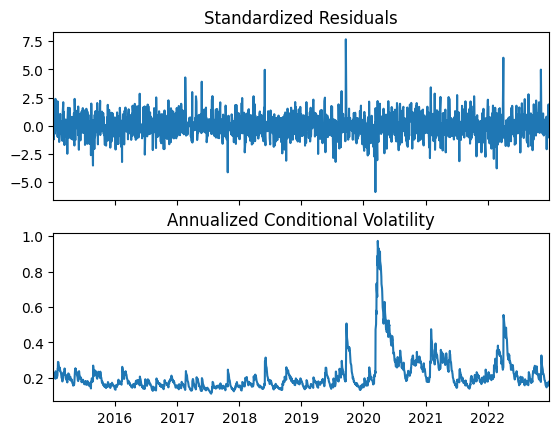

In [36]:
# Plot annualized vol
fig = model.plot(annualize='D')

In [42]:
# Forecast for next 5 days
model_forecast = model.forecast(horizon=60)

# Plot forecasted volatility
fdf = pd.DataFrame(np.sqrt(model_forecast.variance.dropna().T * 252)*100)
fdf.columns = ['Cond_Vol']
px.scatter(fdf, fdf.index, 'Cond_Vol', labels={'index':'Horizon'}, title='GARCH Volatility Forecast')